Connected to tracking-barbell-exercises (Python 3.8.15)

In [1]:
import sys
sys.path.append("../../src")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from features.DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from features.TemporalAbstraction import NumericalAbstraction

# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [2]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../../data/interim/02_outliers_removed_IQR.pkl")
predictor_columns = df.columns[:6]

In [3]:
# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------
for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]
    duration = stop - start
    df.loc[(df["set"] == s), "duration"] = duration.seconds

duration_df = df.groupby(["category"])["duration"].mean()

In [4]:
# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------
df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = (
    1000 / 200
)  # Sampling_frequency (we set frequency = 200 ms when we did the resampling in src/data/make_dataet.py)

cutoff = 1.3
# df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)
# subset = df_lowpass[df_lowpass["set"] == 45]
# print(subset["label"][0])
# fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
# ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
# ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="Butterworth filter")
# ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
# ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    df_lowpass.drop([col + "_lowpass"], axis=1, inplace=True)

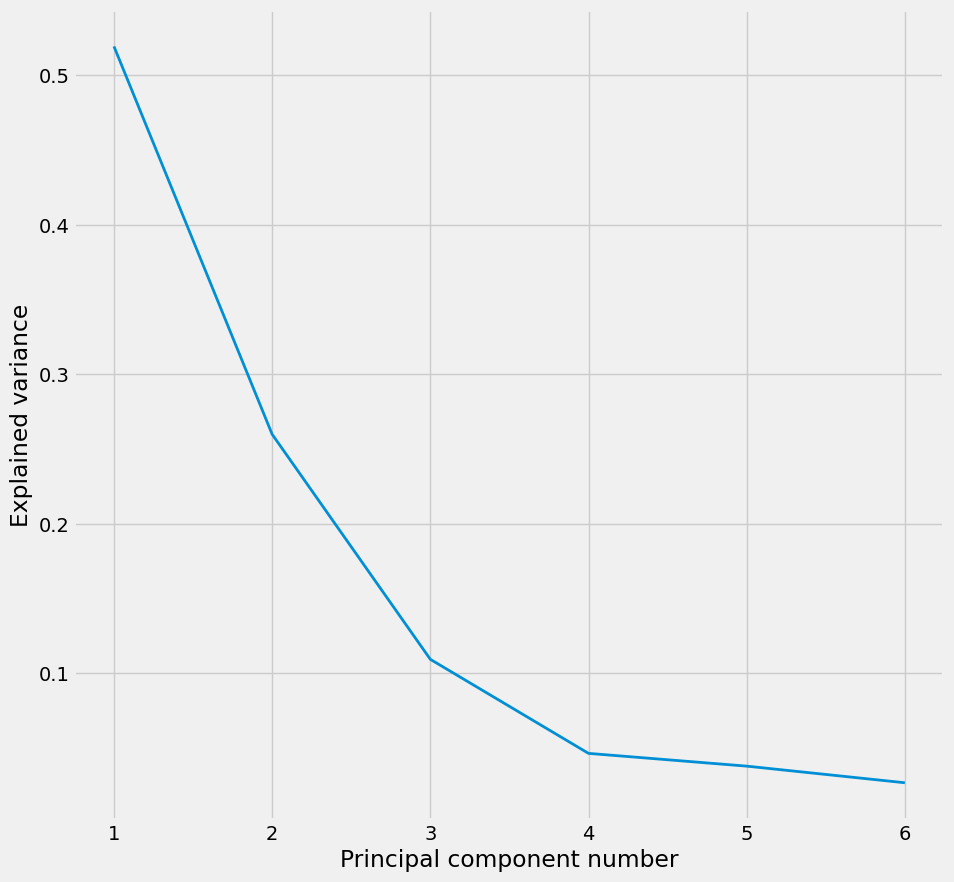

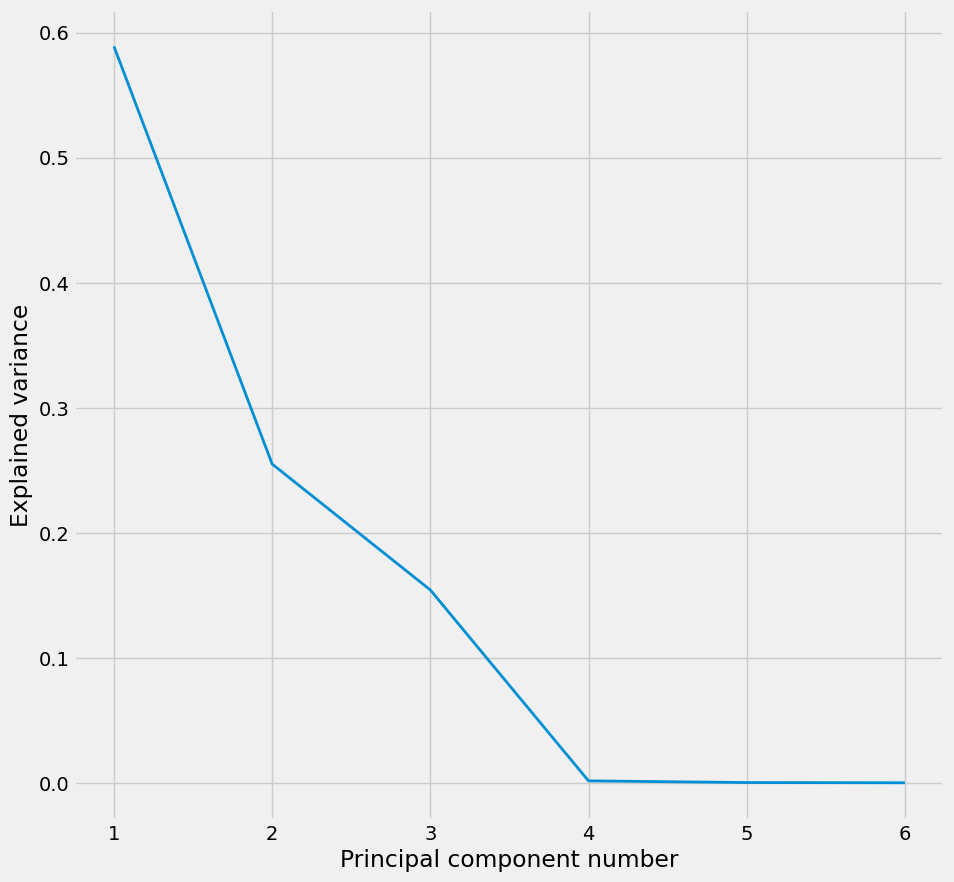

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


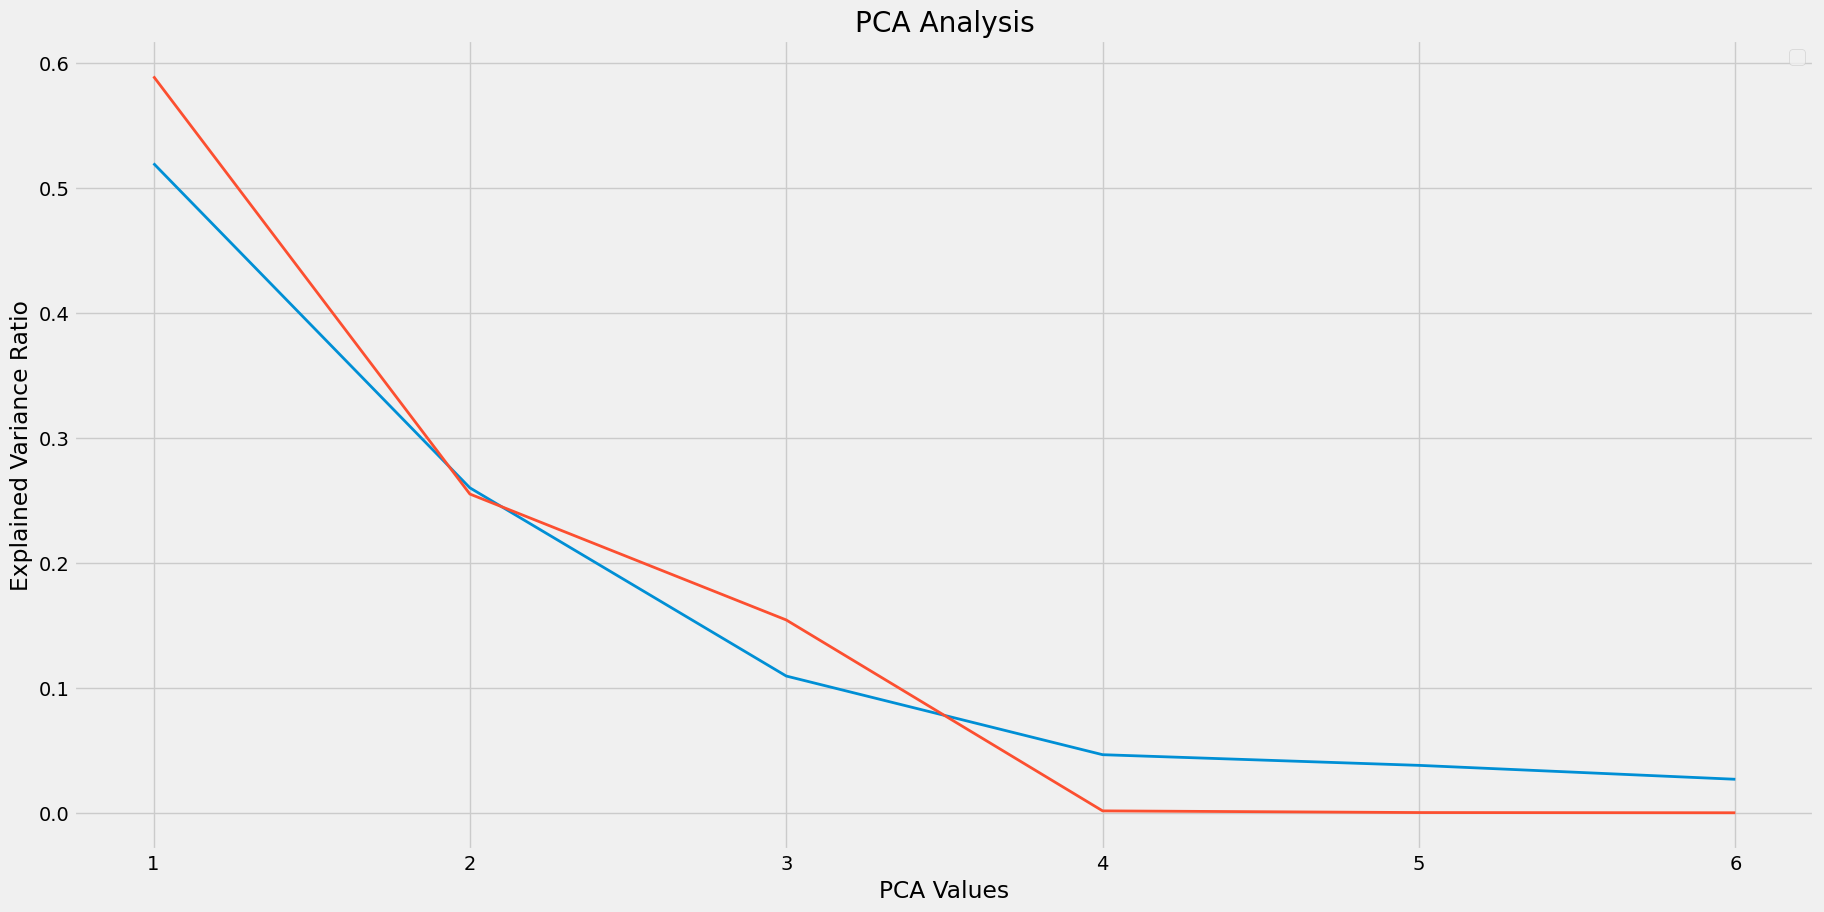

In [5]:
# ----------------------------- ---------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------
# ELBOW TECHNIQUE
# Finding the optimal component number by plotting the variance captured against
# the component number and then selecting the point at which the rate of change
# in variance diminishes (the "elbow"), as this is typically the point at which
# adding more components does not significantly improve the analysis.

df_pca_custom = df.copy()
PCA_custom = PrincipalComponentAnalysis()
pca_values_custom = PCA_custom.determine_pc_explained_variance(
    df_pca_custom, predictor_columns
)

plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pca_values_custom)
plt.xlabel("Principal component number")
plt.ylabel("Explained variance")
plt.show()


from sklearn.decomposition import PCA

df_pca = df_lowpass.copy()
pca = PCA()
pca_values = pca.fit(df_pca[predictor_columns].to_numpy())
pca_values = pca.explained_variance_ratio_
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pca_values)
plt.xlabel("Principal component number")
plt.ylabel("Explained variance")
plt.show()
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(20, 10))
ax.plot(range(1, len(predictor_columns) + 1), pca_values_custom)
ax.plot(range(1, len(predictor_columns) + 1), pca_values)
ax.set_xlabel("PCA Values")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("PCA Analysis")
ax.legend()
plt.show()
pca = PCA(n_components=4, svd_solver="arpack")
df_pca_transformed_np = pca.fit_transform(df_pca[predictor_columns].to_numpy())
df_pca_transformed_pd = pd.DataFrame(
    df_pca_transformed_np,
    index=df_pca.index,
    columns=["pca_1", "pca_2", "pca_3", "pca_4"],
)

df_pca = pd.concat([df_pca, df_pca_transformed_pd], axis=1)